Postcode cm7 3eb

Number of months to search upto 12 3
Braintree, Essex, East of England, England, CM7 3EB, United Kingdom


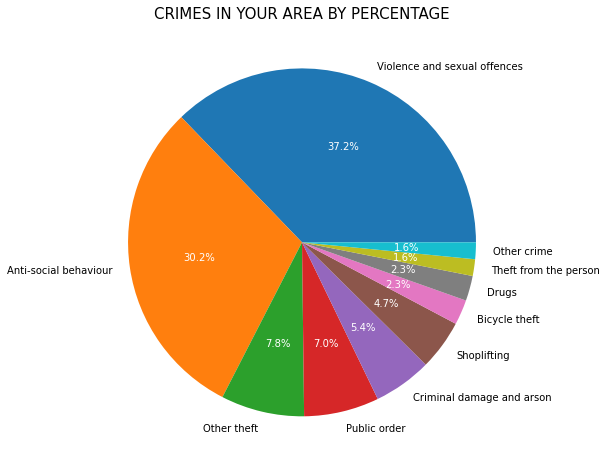


CRIME MAP FOR BRAINTREE
AVERAGES ARE CALCULATED AS CRIME BY TYPE FOR A SPECIFIC GEOGRAPHICAL POINT/CRIME BY TYPE FOR THE ENTIRE REGION


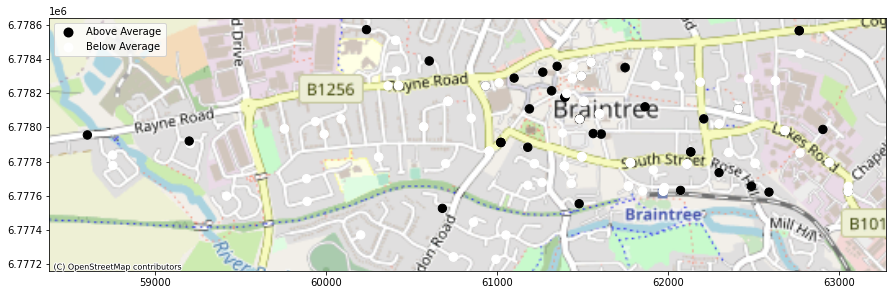

HIGH RISK AREAS
1 On or near Police Station
2 On or near Supermarket
3 On or near Peel Crescent
4 On or near Malyon Close
5 On or near Bus/coach Station
6 On or near High Street
7 On or near Fairfield Road
8 On or near High Street
9 On or near Coggeshall Road
10 On or near Rue De Jeunes

   GET TO KNOW YOUR LOCAL POLICE OFFICERS

SENIOR OFFICERS
Name : BJ Harrington, Rank : Chief Constable
Name : Pippa Mills, Rank : Deputy Chief Constable
Name : Andy Prophet, Rank : Assistant Chief Constable
Name : Nick Downing, Rank : Assistant Chief Constable Essex Police and Kent Police
Name : Mark Gilmartin, Rank : Director of Essex and Kent Support Services
Name : Vicki Harrington, Rank : Director of Strategic Change and Performance
Name : Richard Leicester, Rank : Director of Human Resources

NEIGHBOURHOOD OFFICERS
Name : Craig Carrington, Rank : Chief Insp

Boundary Name: Braintree Town, Boundary ID: 2
Population within Policing boundary 7262
Police Force Name : Essex Police
Contact : {'email': 

In [1]:
import requests
from police_api import PoliceAPI
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')


# Input the postcode and standardises it, to accept postcode with and without spaces.
postcode = input('Postcode ').lower()
sec_part = postcode[-4:]
fir_part = postcode[:len(postcode)-(len(sec_part)-1)]

if sec_part.startswith(' '):
    postcode = postcode
    
else: 
    postcode = fir_part + " " + sec_part[-3:]
print()

# Establishes the length of time to pull data for
time_frame = int(input('Number of months to search upto 12 '))

# Connection to location IQ's API for geoencoding the postcode into coordinates
url = 'https://eu1.locationiq.com/v1/search.php'
data = {'key':'pk.6daa619f784eb097c97ae2df1882b913',
        'country': 'United Kingdom',
        'postalcode': postcode,
       'format':'json'}

response = requests.get(url,params=data)

# Takes the response variable and allocated necessary data into list i.e. latitude and longitude
your_lat = []
your_long = []
your_name = ['Your Location']
display_name = []
for x in response.json():
    lat = x['lat']
    your_lat.append(lat)
    lon = x['lon']
    your_long.append(lon) 
    print(x['display_name'])
    display_name.append(x['display_name'])

# Saves the police data API into this variable
api = PoliceAPI()

# Inputs lat/lon into the API's locate neighbourhood endpoint
n = api.locate_neighbourhood(lat,lon)

# Can tweak dates
dates = api.get_dates()
dates = dates[:time_frame]

# Get crimes for the area using the neighbourhood policing boundary for your lat/lon
# Establishes percentages for each crime cateogory
crime = api.get_crimes_area(n.boundary,date=dates)
number = len(crime)
categories = set([x.category.name for x in crime])
categories_df = pd.DataFrame([x.category.name for x in crime])
categories_df.rename({0:'Type'},axis=1,inplace=True)  
percentage = []
for x in categories: 
    _ = (len(categories_df[categories_df['Type']==x])/len(categories_df))*100
    percentage.append(_)
values = (list(zip(categories,percentage)))
by_percentage = sorted(values,key=lambda x:x[1],reverse=True)

# Builds the pie chart of crimes by percentages
_ = dict(by_percentage[:10])
pie, ax = plt.subplots(figsize=(8,8))
labels = _.keys()
patches, texts,autotexts = plt.pie(x = _.values(),autopct='%.1f%%', labels = labels)
plt.title('CRIMES IN YOUR AREA BY PERCENTAGE',color='black',fontsize=15)
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
plt.show()
print()


# Builds a dataframe of crimes in the interested area, dates, category, coordinates, name of crime
cat = []
lat = []
lon = []
name = []
date = []
for x in dates: 
    _ = api.get_crimes_area(n.boundary,date=x)
    for y in _:
        cat.append(y.category.name)
        lat.append(y.location.latitude) 
        lon.append(y.location.longitude)
        name.append(y.location.name)
        date.append(y.month)
loc_df = pd.DataFrame(list(zip(cat,lat,lon,name,date)))
loc_df2 = loc_df.groupby([1,2,3]).count().sort_values([0,3],ascending=False)
loc_df2 = loc_df2.reset_index()



input_lat = n.centre['latitude']
input_long = n.centre['longitude']
x = input_lat,input_long
x[0]
y = ('%s,%s'%(float(x[0]),float(x[1])))

test = loc_df.rename({1:'Latitude',2:'Longitude',3:'Location Name',0:'Type of Crime'},axis=1)
test2 = test.groupby(['Latitude','Longitude','Location Name','Type of Crime']).count()
test2 = test2.reset_index()
test2 = test2.rename({4:'Count'},axis=1)

averages = []
for x in range(len(test2)):
    for y in range(len(test2.groupby('Type of Crime')['Count'].mean().keys())):
        if test2.iloc[x]['Type of Crime']==test2.groupby('Type of Crime')['Count'].mean().keys()[y]:
              averages.append(test2.groupby('Type of Crime')['Count'].mean()[y])
test2['Averages'] = averages
test2['Status'] = np.where(test2['Count']>test2['Averages'],'Above Average','Below Average')

_lat = []
_lon = []
for x in test2['Latitude'].values:
    x = float(x)
    _lat.append(x)
for x in test2['Longitude'].values:
    x = float(x)
    _lon.append(x)

geometry = [Point(xy) for xy in zip(_lon,_lat)]
crs = {'init': 'epsg:4326'}
geo_test2 = gpd.GeoDataFrame(test2,crs = crs,geometry=geometry)
geo_test2 = geo_test2.to_crs(epsg=3857)

ax = geo_test2.plot(column='Status',cmap='gist_heat',figsize=(15,10),marker='o',markersize=70,legend=True,vmax=1,vmin=0)
ax.set_title(print('CRIME MAP FOR %s\nAVERAGES ARE CALCULATED AS CRIME BY TYPE FOR A SPECIFIC GEOGRAPHICAL POINT/CRIME BY TYPE FOR THE ENTIRE REGION'%(display_name[0].split(',')[0]).upper()), fontsize=20)
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik,zoom=14)
plt.show()

print('HIGH RISK AREAS')
for x,y in enumerate(loc_df2[3].values[:10]):
    print(x+1,y)
print()
print('   GET TO KNOW YOUR LOCAL POLICE OFFICERS')
print()
print('SENIOR OFFICERS')
for x in (n.force.senior_officers):
    if len(x.name)>0:
        print('Name : %s, Rank : %s' %(x.name, x.rank))
    else: 
        print('No Data Found')
print()

print('NEIGHBOURHOOD OFFICERS')
for x in n.officers: 
    print('Name : %s, Rank : %s'%(x.name,x.rank))
print()                 
print('Boundary Name: %s, Boundary ID: %s' %(n.name,n.id))
print('Population within Policing boundary %s'%(n.population))
print('Police Force Name : %s'%(n.force.name))
print('Contact : %s'%(n.contact_details))
print()  